In [1]:
import timeit

import numpy as np
import pandas as pd
import tqdm
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = "large"

In [3]:
import pyquaternion  # pip install pyquaternion --user
import quaternion  # pip install numpy_quaternion --user

import rowan  # pip install rowan --user

/home/vramasub/.local/lib/python3.6/site-packages/quaternion/numba_wrapper.py:29: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from either numbapro or numba.
This means that the code will run MUCH more slowly.
You probably REALLY want to install numba / numbapro.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [4]:
def arr_to_pyquat(arr):
    if len(arr.shape) > 1:
        pq_arr = np.empty(arr.shape[:-1], dtype="object")
        for i, x in enumerate(arr):
            pq_arr[i] = pyquaternion.Quaternion(x)
    else:
        pq_arr = np.array([pyquaternion.Quaternion(arr)])
    return pq_arr


def arr_to_npquat(arr):
    return quaternion.as_quat_array(arr)


pyquat_times = {}
quat_times = {}
rowan_times = {}
Ns = [10, 100000]
num = 10
pqlim = 1e8

In [5]:
pyquat_times["Multiply"] = []
quat_times["Multiply"] = []
rowan_times["Multiply"] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)
    y = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times["Multiply"].append(
            timeit.timeit(
                "x*y",
                setup="from __main__ import x, y, arr_to_pyquat; x = arr_to_pyquat(x); y = arr_to_pyquat(y)",
                number=num,
            )
        )
    quat_times["Multiply"].append(
        timeit.timeit(
            "x*y",
            setup="from __main__ import x, y, arr_to_npquat; x = arr_to_npquat(x); y = arr_to_npquat(y)",
            number=num,
        )
    )
    rowan_times["Multiply"].append(
        timeit.timeit(
            "rowan.multiply(x, y)", setup="from __main__ import x, y, rowan", number=num
        )
    )

In [6]:
pyquat_times["Exponential"] = []
quat_times["Exponential"] = []
rowan_times["Exponential"] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times["Exponential"].append(
            timeit.timeit(
                "for i in range(len(x)): pyquaternion.Quaternion.exp(x[i])",
                setup="from __main__ import x, pyquaternion, arr_to_pyquat; x = arr_to_pyquat(x);",
                number=num,
            )
        )
    quat_times["Exponential"].append(
        timeit.timeit(
            "np.exp(x)",
            setup="from __main__ import x, arr_to_npquat, np; x = arr_to_npquat(x);",
            number=num,
        )
    )
    rowan_times["Exponential"].append(
        timeit.timeit("rowan.exp(x)", setup="from __main__ import x, rowan", number=num)
    )

In [7]:
pyquat_times["Conjugate"] = []
quat_times["Conjugate"] = []
rowan_times["Conjugate"] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times["Conjugate"].append(
            timeit.timeit(
                "for i in range(len(x)): x.conjugate",
                setup="from __main__ import x, arr_to_pyquat; x = arr_to_pyquat(x);",
                number=num,
            )
        )
    quat_times["Conjugate"].append(
        timeit.timeit(
            "x.conjugate()",
            setup="from __main__ import x, arr_to_npquat; x = arr_to_npquat(x);",
            number=num,
        )
    )
    rowan_times["Conjugate"].append(
        timeit.timeit(
            "rowan.conjugate(x)", setup="from __main__ import x, rowan", number=num
        )
    )

In [8]:
pyquat_times["Norm"] = []
quat_times["Norm"] = []
rowan_times["Norm"] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times["Norm"].append(
            timeit.timeit(
                "for i in range(len(x)): x[i].norm",
                setup="from __main__ import x, arr_to_pyquat; x = arr_to_pyquat(x);",
                number=num,
            )
        )
    quat_times["Norm"].append(
        timeit.timeit(
            "np.abs(x)",
            setup="from __main__ import x, np, arr_to_npquat; x = arr_to_npquat(x);",
            number=num,
        )
    )
    rowan_times["Norm"].append(
        timeit.timeit(
            "rowan.norm(x)", setup="from __main__ import x, rowan", number=num
        )
    )

In [9]:
pyquat_times["To Matrix"] = []
quat_times["To Matrix"] = []
rowan_times["To Matrix"] = []
for N in tqdm.tqdm_notebook(Ns):
    x = rowan.random.rand(N)

    if N < pqlim:
        pyquat_times["To Matrix"].append(
            timeit.timeit(
                "for i in range(len(x)): x[i].rotation_matrix",
                setup="from __main__ import x, arr_to_pyquat; x = arr_to_pyquat(x);",
                number=num,
            )
        )
    quat_times["To Matrix"].append(
        timeit.timeit(
            "quaternion.as_rotation_matrix(x)",
            setup="from __main__ import x, quaternion, arr_to_npquat; x = arr_to_npquat(x);",
            number=num,
        )
    )
    rowan_times["To Matrix"].append(
        timeit.timeit(
            "rowan.to_matrix(x)", setup="from __main__ import x, rowan", number=num
        )
    )

In [10]:
pyquat_times["N"] = list(np.array(Ns)[np.array(Ns) < pqlim])
quat_times["N"] = Ns
rowan_times["N"] = Ns

In [11]:
df_pq = pd.DataFrame(pyquat_times).melt(
    id_vars="N", var_name="operation", value_name="pyquaternion"
)
df_nq = pd.DataFrame(quat_times).melt(
    id_vars="N", var_name="operation", value_name="npquaternion"
)
df_r = pd.DataFrame(rowan_times).melt(
    id_vars="N", var_name="operation", value_name="rowan"
)
df = df_r.merge(df_nq, on=["N", "operation"])
df = df.merge(df_pq, on=["N", "operation"], how="left")
df.fillna(0, inplace=True)
df["pyquaternion"] /= df["N"]
df["pyquaternion"] *= 1e6
df["npquaternion"] /= df["N"]
df["npquaternion"] *= 1e6
df["rowan"] /= df["N"]
df["rowan"] *= 1e6

In [12]:
view = df.groupby(["N", "operation"]).mean()
view["rowan vs. npq"] = view["rowan"] / view["npquaternion"]
view["pyq vs. rowan"] = view["pyquaternion"] / view["rowan"]
view

rowan  npquaternion  pyquaternion  rowan vs. npq  \
N      operation                                                            
10     Conjugate     14.219387      1.645903      0.965106       8.639261   
       Exponential  176.208094      2.648006    491.397409      66.543686   
       Multiply     127.368094      1.953496    220.462098      65.200091   
       Norm          15.173992      1.513795     41.527301      10.023809   
       To Matrix    185.719715    137.050101    239.094393       1.355123   
100000 Conjugate      0.155787      0.027460      0.522096       5.673227   
       Exponential    1.423360      0.607103    350.614734       2.344510   
       Multiply       0.721474      0.060493    160.553924      11.926642   
       Norm           0.172119      0.030692     12.108950       5.607998   
       To Matrix      0.869151      0.874250    155.389069       0.994167   

                    pyq vs. rowan  
N      operation                   
10     Conjugate         0.067873  
       Exponential       2.788733  
       Multiply          1.730905  
       Norm              2.736742  
       To Matrix         1.287394  
100000 Conjugate         3.351350  
       Exponential     246.328931  
       Multiply        222.536107  
       Norm             70.352381  
       To Matrix       178.782588

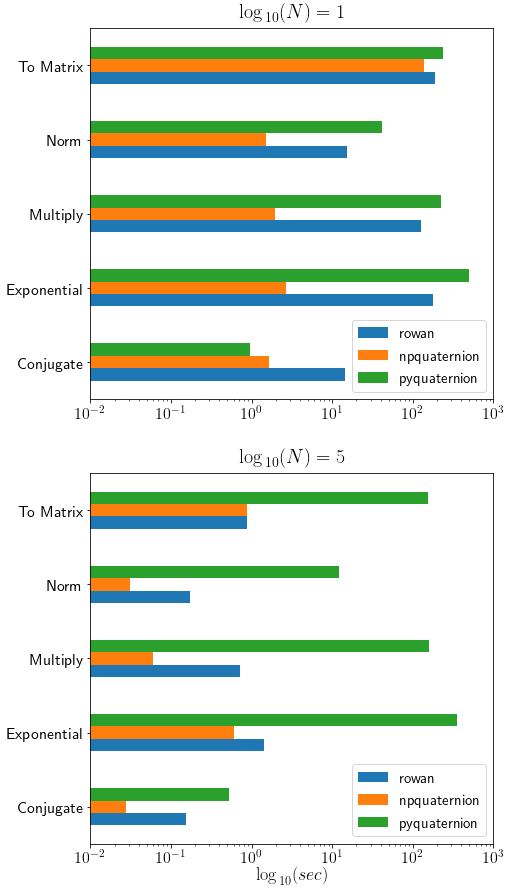

In [25]:
cols = list(col["color"] for col in plt.rcParams["axes.prop_cycle"])
fig, axes = plt.subplots(2, 1, figsize=(8, 15))
ax = (
    df[df["N"] == Ns[0]]
    .drop(["N"], axis=1)
    .groupby(["operation"])
    .mean()
    .plot.barh(
        ax=axes[0],
        logx=True,
        color=cols[0:3],
        title=rf"$\log_{{\,10}}(N) = {int(np.log10(Ns[0]))}$",
        xlim=(10**-2, 10**3),
        legend=False,
    )
)
ax = (
    df[df["N"] == Ns[1]]
    .drop(["N"], axis=1)
    .groupby(["operation"])
    .mean()
    .plot.barh(
        ax=axes[1],
        logx=True,
        color=cols[0:3],
        title=rf"$\log_{{\,10}}(N) = {int(np.log10(Ns[1]))}$",
        xlim=(10**-2, 10**3),
        legend=False,
    )
)
ax.set_xlabel(r"$\log_{\,10}(sec)$", fontsize=18)
for ax in axes.flatten():
    ax.set_ylabel("")
    ax.legend(loc="best", fontsize=15)
    ax.title.set_fontsize(20)
    # ax.tick_params(axis='both', which='major', labelsize=16)

fig.subplots_adjust(left=0.2)
plt.show()
fig.savefig("Performance.pdf")